# Hyperparameter optimization via cross-validation

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
import sklearn.metrics as metrics


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [2]:
#Inlezen van de dataset
dataset = pd.read_csv('diabetes.csv')
dataset.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,92,62,32,126,32.0,85.0,46,0
1,2,125,60,20,140,33.8,88.0,31,0
2,0,117,80,31,53,45.2,89.0,24,0
3,1,87,78,27,32,34.6,101.0,22,0
4,3,116,74,15,105,26.3,107.0,24,0
5,1,128,82,17,183,27.5,115.0,22,0
6,4,110,76,20,100,28.4,118.0,27,0
7,6,105,70,32,68,30.8,122.0,37,0
8,1,157,72,21,168,25.6,123.0,24,0
9,2,102,86,36,120,45.5,127.0,23,1


In [3]:
# Opsplitsen in features en targets
y = dataset['Outcome'].values
X = dataset.drop('Outcome',axis=1)

# Opsplitsen van data in een training en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 100, random_state =0)
print(X_train.shape)

# Normalisatie van de dataset

scaler = preprocessing.StandardScaler().fit(X_train)  # Normaliseer naar gemiddelde = 0 en standaardafwijking = 1

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

(280, 8)


## Grid Search

Fitting 15 folds for each of 70 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.7s


Best accuracy :  0.810916179337232
Best parameters : {'C': 8.894444444444444, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        63
           1       0.64      0.49      0.55        37

    accuracy                           0.71       100
   macro avg       0.69      0.66      0.67       100
weighted avg       0.70      0.71      0.70       100

[[53 10]
 [19 18]]
71.0


[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    2.6s finished


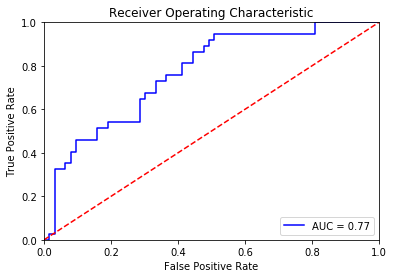

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC(probability=True)
paramaters = [ 
        {'kernel': ['linear'], 'C': np.linspace(0.01,20,10)},
        {'kernel': ['rbf'], 'C': np.linspace(0.01,20,10), 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2]},
        {'kernel': ['poly'], 'C':np.linspace(0.01,20,10)} ]
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy', # roc_auc, f1_weighted, f1_macro, recall, ...
                           cv = 15,
                           n_jobs = -1,
                           verbose =5)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 




# ROC
probs = grid_search.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random search

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  77 out of 100 | elapsed:    0.2s remaining:    0.1s


Best accuracy :  0.7892857142857144
Best parameters : {'C': 0.797199485272474, 'gamma': 0.18646596054486508, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.72      0.84      0.77        63
           1       0.62      0.43      0.51        37

    accuracy                           0.69       100
   macro avg       0.67      0.64      0.64       100
weighted avg       0.68      0.69      0.68       100

[[53 10]
 [21 16]]
69.0


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


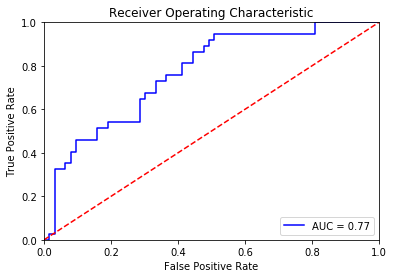

In [5]:
# Train een SVM via random search

from sklearn.model_selection import RandomizedSearchCV
# distributions
from scipy.stats import randint 
from scipy.stats import uniform



model = SVC(probability=True)
parameters = {'kernel': ['linear','rbf','poly'],
              'C': uniform(0.01, 20), # haal C uit een random uniform distribution
              'gamma': uniform(0.001, 0.2)}


n_iter_search = 20


random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


# ROC
probs = grid_search.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Bayes search

Te installeren via:  pip3 install git+https://github.com/darenr/scikit-optimize 

/home/florian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s fini

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Best accuracy :  0.7892857142857143
Best parameters : {'C': 18.39020358675347, 'gamma': 0.001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.75      0.89      0.81        63
           1       0.72      0.49      0.58        37

    accuracy                           0.74       100
   macro avg       0.73      0.69      0.70       100
weighted avg       0.74      0.74      0.73       100

[[56  7]
 [19 18]]
74.0


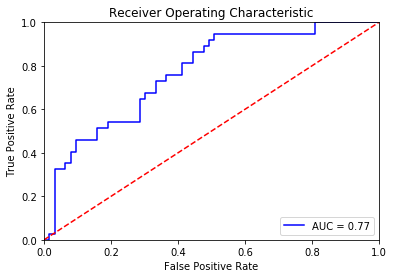

In [6]:
# grid search via BayesSearchCV


#Bayessearch cv uit Scikit-optimize
from skopt import BayesSearchCV #scikit-optimize

# distributions
from scipy.stats import randint 
from scipy.stats import uniform


model = SVC(probability=True)
parameters = {'kernel': ['linear','rbf','poly'],
              'C': (0.01, 100,'uniform'), 
              'gamma': (0.001, 0.2,'uniform')}

n_iter_search = 20

Bayes_search = BayesSearchCV(model,parameters,n_iter=n_iter_search,cv=5,verbose=1,n_jobs=-1)


Bayes_search.fit(X_train, y_train)

best_accuracy = Bayes_search.best_score_ 
best_parameters = Bayes_search.best_params_  

print('Best accuracy : ', Bayes_search.best_score_)
print('Best parameters :',Bayes_search.best_params_  )

y_pred = Bayes_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


# ROC
probs = grid_search.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Leercurve

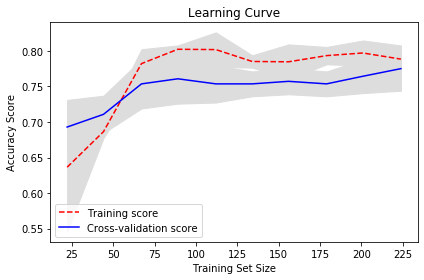

In [7]:
from sklearn.model_selection import learning_curve 

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVC(kernel='linear',C=0.01),
                                                        X_train, y_train,cv=5, scoring='accuracy',
                                                        n_jobs=-1,train_sizes=np.linspace(0.1, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="blue", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()